# Scaling ColPali with Qdrant

Qdrant supports [multivector representations](https://qdrant.tech/documentation/concepts/vectors/#multivectors), which are essential for effectively utilizing models like **ColPali**, **ColQwen**, or **ColBERT** in a vector database.


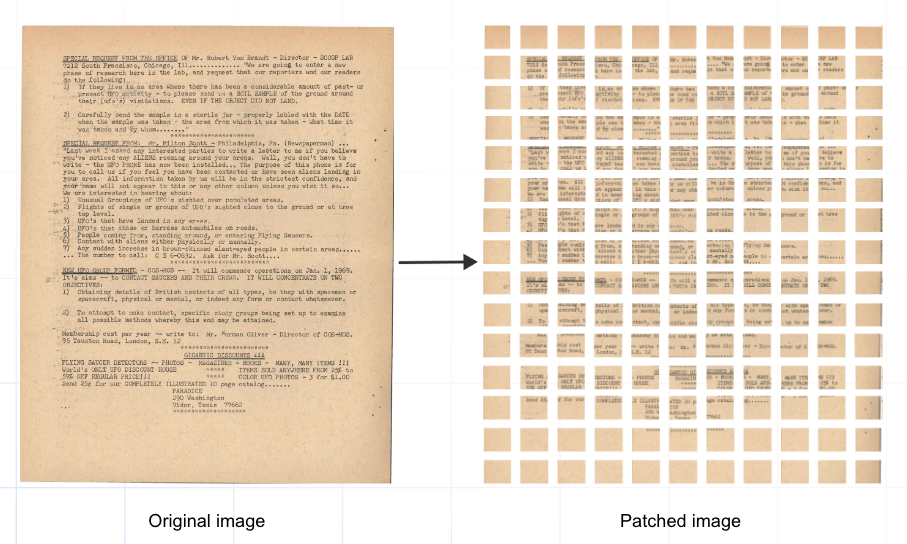

## The Problem with Scaling
**ColPali** generates over **1,000 vectors for just one page of a PDF**. While this is manageable for small-scale tasks, in a real-world production setting where you may need to store hundreds od thousands of PDFs, the challenge of scaling becomes significant.

### Why Scaling is Difficult

Scaling ColPali representations is computationally intensive. To illustrate this, let's examine the construction of an [**HNSW index**](https://qdrant.tech/articles/what-is-a-vector-database/#1-indexing-hnsw-index-and-sending-data-to-qdrant) (a common indexing algorithm in vector databases).

While HNSW does not actually compare every point to every other point, let's assume so to demonstrate how the number of multivectors significantly affects computational speed.

Consider this example:
- **Number of pages**: 20,000
- **Number of embeddings per page (ColPali)**: ~1,000 vectors
- **Vector dimensions (ColPali)**: 128 dimensions

If we were to compare every vector to every other vector, the number of comparisons required to build the index would be:
$$
1000 \times 1000 \times 128 \times 20,000 = 2.56 \, \text{trillion comparisons!}
$$

This quadratic relationship between the number of multivectors and the computational cost makes it **challenging** to:
1. Build or rebuild the index effectively as the data scales.
2. Perform searches quickly, even if the index gets built.

Optimizing the number of multivectors is critical for addressing these challenges, as even small reductions in their count can lead to significant performance improvements.

## Optimization Strategies
### Existing Solutions
To address these challenges, some optimization strategies have already been proposed:

1. **Binary Quantization**: Convert vectors to binary format to speed up comparisons. This is an easy approach, offering a possible **40x speedup** compared to using full `float32` precision. However, this improvement is linear and we aim for a **quadratic speedup** by reducing the number of multivectors themselves.
   
2. **Hamming Distance with Parallelization**: Vespa has proposed advanced techniques, such as using Hamming distance on binary quantized vectors combined with parallelized query multivector processing. You can read more about their approach [here](https://blog.vespa.ai/scaling-colpali-to-billions/). It’s also a promising solution for optimizing ColPali at scale.

However, none of these approaches test **reducing the number of vectors for ColPali’s image representation**. This is the direction we’ve chosen to investigate. By reducing the number of multivectors, we target a **quadratic reduction in computational costs**.

## Exploring a New Approach
### Reducing Multivectors Number

The **number of comparisons** grows **quadratically** with the number of multivectors.
For example, if we reduce the number of vectors from 1,000 to 100:
    $$
    100 \times 100 \times 128 = 1,3 \ \text{million comparisons (vs. 128 million on 1,000 multivectors!)}
    $$

This reduction would result in a **100x improvement**!

We can't simply remove random vectors from ColPali 1024-vector representations because:
- Each vector corresponds to a specific part of the PDF page.
- Every part of the page might contain critical information for retrieval tasks.

### Pooling
Our proposed solution is to reduce the number of vectors by applying a **pooling operation**. This operation combines vectors in a meaningful way, ensuring that important information from the original data is preserved.

Applying pooling to rows or columns of ColPali-generated vectors can compress **1,024 vectors** into just **32**! Imagine the difference in computational speed and efficiency with such a reduction.

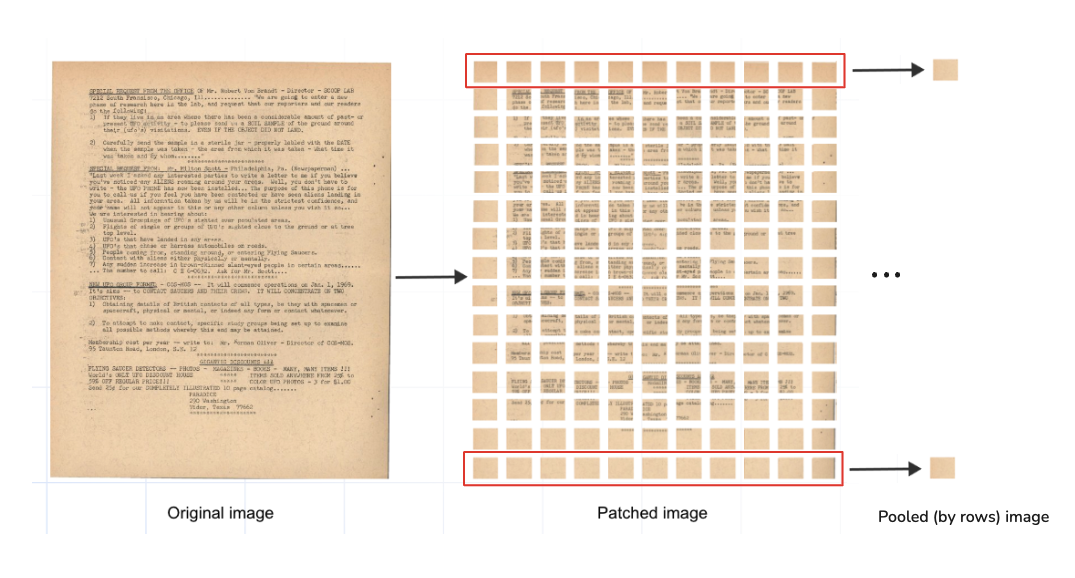

Pooling is widely used in machine learning, with two of the most common types being:
1. **Max Pooling**: Takes the maximum value for each dimension (128 dimensions per ColPali vector) across a group of vectors.
2. **Mean Pooling**: Averages the values for each matching dimension across the group of vectors.

32 ColPali vectors (rows, as in the image above, or columns) can be pooled into just **1 vector** per group.

### Quality concerns

While pooling is straightforward, it hasn't yet been tested at scale for ColPali. The key question is: **Will compressing vectors by 30x impact original ColPali retrieval quality so much that it becomes unusable?**

We hypothesized that using pooled vectors alone would likely result in a significant drop in retrieval quality. So, we considered a hybrid solution: **What if we used the pooled vectors for the initial retrieval stage and the original ColPali model for reranking?**

### The "ColPali as a Reranker" Experiment

This idea led to the **"ColPali as a Reranker" experiment**:
1. Use pooled vectors (max or mean pooled) as a **first-stage retriever**. These are much smaller and faster for large-scale searches.
2. Use the original ColPali model as a **reranker**, refining the results from the first-stage retrieval. Reranking a small number of retrieved vectors is far more computationally feasible than using ColPali as a first-scale retriever.

The results are documented in the notebooks **"ColPali as a Reranker I"** and **"ColPali as a Reranker II"**. Spoiler: **It works!** Using mean-pooled per row vectors as the first-stage retriever, combined with original ColPali for reranking, retains the original retrieval quality while achieving a significant speedup.

### Bonus Tricks and Tips

In addition to testing pooling strategies, the demo includes tips for experimenting further with ColPali and Qdrant at scale.

You’ll also learn how to:
1. Perform **batch uploads** for large datasets.
2. Use **Qdrant’s batch search** and **Qdrant’s search with prefetch**.

These are crucial for building scalable solutions and optimizing retrieval tasks in real-world projects.


In [ ]:
!pip install -q "colpali_engine>=0.3.1" "datasets" "huggingface_hub[hf_transfer]" "transformers>=4.45.0" "qdrant-client"

In [ ]:
from colpali_engine.models import ColPali, ColPaliProcessor
from datasets import load_dataset
from google.colab import userdata
from qdrant_client import QdrantClient
from qdrant_client.http import models
import torch
from tqdm import tqdm

## Setting Up Your Qdrant Cluster

To run these experiments, we’re using a **Qdrant cluster**. If you’re just getting started, you can set up a **free-tier cluster** for testing and exploration. Follow the instructions in the documentation:  
[How to Create a Free-Tier Qdrant Cluster](https://qdrant.tech/documentation/cloud/create-cluster/?q=free+tier#free-clusters)

> **Note:** While a free-tier cluster is sufficient for experimenting with smaller-scale setups, the experiments demonstrated in this tutorial were conducted on a larger, more robust Qdrant cluster.

In [ ]:
client = QdrantClient(
    url="https://187badc9-1579-40af-b564-cf6aa73c84c3.us-east4-0.gcp.cloud.qdrant.io",
    api_key=userdata.get('qdrant_cloud'),
)

collection_name = "colpali_demo"

In [ ]:
model_name = (
    "vidore/colpali-v1.3"
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
).eval()

colpali_processor = ColPaliProcessor.from_pretrained(
    model_name
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

Below is a screenshot of the **Qdrant cluster configuration** we used for our experiments.

> **Note:** This configuration is tailored specifically for our testing use case and is not intended as a recommendation for production setups. For production environments, you should adjust the configuration based on your specific workload and scalability requirements.


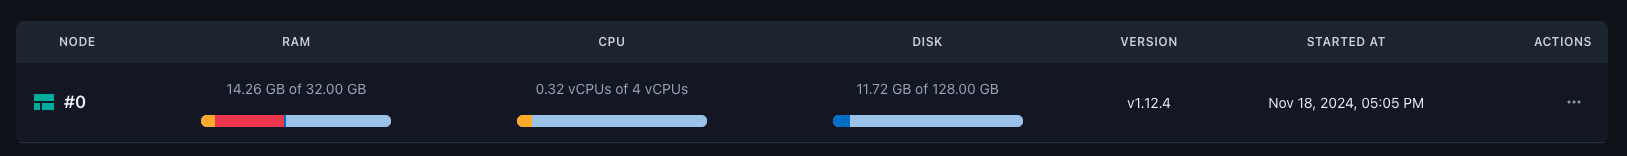

## Qdrant Collection Configuration

For our experiments, we configured the **Qdrant collection** as shown below.

> **Note:** This collection configuration is optimized for experimentation and may not suit production environments without adjustments.

In [ ]:
client.create_collection(
    collection_name=collection_name,
    shard_number=4,
    optimizers_config=models.OptimizersConfigDiff(memmap_threshold=0), #since we want to test retrieval speed without Disk caching, vectors are always in RAM
    vectors_config={
        "initial":
            models.VectorParams(
                  size=128,
                  distance=models.Distance.COSINE,
                  on_disk=False, #since we want to test retrieval speed without Disk caching, vectors are always in RAM
                  multivector_config=models.MultiVectorConfig(
                      comparator=models.MultiVectorComparator.MAX_SIM
                  ),
                  quantization_config=models.BinaryQuantization(
                      binary=models.BinaryQuantizationConfig(
                          always_ram=True
                      ),
                  ),
            ),
        "max_pooling": models.VectorParams(
                size=128,
                distance=models.Distance.COSINE,
                on_disk=False, #since we want to test retrieval speed without Disk caching, vectors are always in RAM
                multivector_config=models.MultiVectorConfig(
                    comparator=models.MultiVectorComparator.MAX_SIM
                ) #binary quantization won't work well on max pooling, so there is no sense in using it; we won't have too many negative values
            ),
        "mean_pooling": models.VectorParams(
                size=128,
                distance=models.Distance.COSINE,
                on_disk=False, #since we want to test retrieval speed without Disk caching, vectors are always in RAM
                multivector_config=models.MultiVectorConfig(
                    comparator=models.MultiVectorComparator.MAX_SIM
                ),
                quantization_config=models.BinaryQuantization(
                    binary=models.BinaryQuantizationConfig(
                        always_ram=True
                    ),
                ),
            )
    }
)

True

## Dataset for Experiments

To test our retrieval and reranking strategies at scale, we aimed to work with a **large PDF retrieval dataset** containing **20,000+ points**. Unfortunately, we couldn’t find a ready-made opensourced dataset of this size suitable for our task. As a result, we decided to combine three datasets to create a custom collection:

1. **ViDoRe Benchmark**
2. **UFO Dataset** By Daniel van Strien, previously mentioned in our [ColPali video](https://www.youtube.com/watch?v=_A90A-grwIc). You can find a detailed guide on generating this dataset here:  
   [Guide to Generating the UFO Dataset](https://danielvanstrien.xyz/posts/post-with-code/colpali/2024-09-23-generate_colpali_dataset.html).  
3. **DocVQA Dataset**: The largest of the three, though not primarily designed for retrieval tasks. It served as a good source for expanding our collection.


To ensure our dataset met the goal of **20,000+ unique PDFs**, we performed **deduplication**.

### Dataset Sources and Upload Process

We uploaded the **ViDoRe** and **UFO** datasets directly from Hugging Face. Below are the links to the datasets:  
- [ViDoRe Benchmark](https://huggingface.co/collections/vidore/vidore-benchmark-667173f98e70a1c0fa4db00d)  
- [UFO Dataset](https://huggingface.co/datasets/davanstrien/ufo-ColPali)

For the [**DocVQA dataset**](https://www.docvqa.org/datasets/docvqa), the upload process was slightly different due to its absence on HuggingFace. However, the overall approach for uploading vectors to Qdrant Cloud remained consistent across all datasets.

Here, we show an example of uploading the `infovqa_test_subsampled` part of the **ViDoRe Benchmark** to a Qdrant collection.


In [ ]:
dataset = load_dataset("vidore/infovqa_test_subsampled", split="test")
unique_indices = dataset.to_pandas().drop_duplicates(subset="image_filename", keep="first").index #to remove repeating PDF pages with different queries
dataset = dataset.select(unique_indices)

#dataset = dataset.filter(lambda x: x['parsed_into_json']) #for the UFO dataset, to exclude ones where synthetic queries generated by LLM weren't parseable

README.md:   0%|          | 0.00/2.45k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

## Adjusting for ColPali's Specifics

In theory, ColPali is said to generate **1,024 vectors per PDF page**, but in practice, it’s actually **1,030 vectors**. This discrepancy arises because the ColPali pre-processor prepends the text `"<bos>Describe the image."` to each image, generating an additional **6 multivectors**.

In [ ]:
with torch.no_grad(): #to show that colPali returns 1024 <image> tokens and then "<bos>Describe the image." for the last 6 tokens, that's why it's 1030 multivectors for an image
    batch_images = colpali_processor.process_images([dataset[0]["image"]]).to(colpali_model.device)
    print(colpali_processor.decode(batch_images.input_ids[0]))

<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image

For our experiments, we chose to **preserve these 6 additional vectors**. As a result our pooling operation compresses the original **1,030 vectors (1,024 + 6)** into **38 vectors (32 pooled + 6 preserved)**.

In [ ]:
batch_size = 16 #based on GPU's
image_seq_length = 1024 #the parameter of ColPali https://huggingface.co/vidore/colpali-v1.3/blob/main/preprocessor_config.json

def embed_and_upload_batch(image_batch, payload_batch, id_start):
    batch_size_current = len(image_batch)

    with torch.no_grad():
        batch_images = colpali_processor.process_images(image_batch).to(colpali_model.device)
        image_embeddings = colpali_model(**batch_images)

    # Process max and mean pooled embeddings per row of image (PDF page) grid
    special_tokens = image_embeddings[:, image_seq_length:, :]
    max_pool = torch.cat((torch.max(image_embeddings[:, :image_seq_length, :].reshape((batch_size_current, 32, 32, 128)), dim=2).values, special_tokens), dim=1)
    mean_pool = torch.cat((torch.mean(image_embeddings[:, :image_seq_length, :].reshape((batch_size_current, 32, 32, 128)), dim=2), special_tokens), dim=1)

    try:
        client.upsert(
            collection_name=collection_name,
            points=models.Batch( #batch upsert
                ids=list(range(id_start, id_start + batch_size_current)), #id's incremental, can be replaced by uuid's
                payloads=payload_batch,
                vectors={
                    "max_pooling": max_pool.cpu().float().numpy().tolist(), #batch upsert of named vectors
                    "initial": image_embeddings.cpu().float().numpy().tolist(),
                    "mean_pooling": mean_pool.cpu().float().numpy().tolist()
                    }
            )
        )
    except Exception as e:
        print(f"Error during upsert: {e}")

with tqdm(total=len(dataset), desc="Uploading Progress") as pbar:
    existing_amount_of_points = client.count(
        collection_name=collection_name,
        exact=True,
    ).count #for incremental IDs, a good (better) option is to use UUIDs; however, this way was more handy in our experiment
    dataset_folder = 'vidore'
    dataset_source = 'ViDoRe_infovqa'
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        images = batch["image"]
        batch_size_current = len(images)
        try:
            embed_and_upload_batch(
                images,
                [
                    {"page": f'''https://storage.googleapis.com/demo_colpali/{dataset_folder}/{dataset_source}_{j}.jpeg''', #we placed PDFs in Google Storage, so we can see them rendered in our Cloud UI
                     "query": dataset[j]["query"]} for j in range(i, i + batch_size_current) #for the ufo dataset it's "specific_detail_query";
                ],
                i + existing_amount_of_points

            )
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue
        # Update the progress bar
        pbar.update(batch_size_current)
print("Uploading complete!")

Uploading Progress: 100%|██████████| 500/500 [04:35<00:00,  1.81it/s]

Uploading complete!


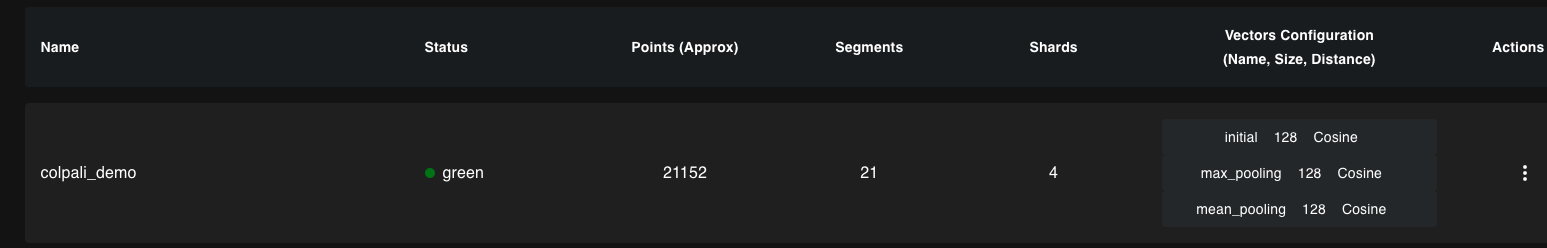

In [ ]:
#to check a point from the collection
client.retrieve(
    collection_name=collection_name,
    ids=[16900]
)

[Record(id=16900, payload={'page': 'https://storage.googleapis.com/demo_colpali/vidore/ViDoRe_syntheticDocQA_energy_24.jpeg', 'query': "What percentage of EIB Group's 2022 gross mobility emissions came from business travel flights?"}, vector=None, shard_key=None, order_value=None)]

With all vectors successfully uploaded to the Qdrant collection, we’re now ready to begin experimenting!

The goal of this experiment is to evaluate how the **"ColPali as a Reranker"** approach compares to using the original ColPali for retrieval. Specifically, we’ll test:
- The quality of results when pooled vectors are used as the first-stage retriever.
- The impact on retrieval speed and scalability with this hybrid setup.

In the next steps, we’ll measure:
1. Retrieval performance using pooled vectors.
2. Final reranking effectiveness using the full ColPali model.

Let’s dive into the comparison and see how well this optimized approach performs in **"ColPali as a reranker II"**!